In [2]:
!pip install seaborn scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, coint
from scipy.stats import pearsonr

Defaulting to user installation because normal site-packages is not writeable


In [4]:
data = pd.read_csv("data.csv")
data.columns

Index(['TIMESTAMP', 'LAST_PRICE_HSI', 'TURNOVER_VOLUME_HSI',
       'LAST_BID_PRICE_HSI', 'LAST_ASK_PRICE_HSI', 'LAST_BID_VOLUME_HSI',
       'LAST_ASK_VOLUME_HSI', 'LAST_PRICE_HHI', 'TURNOVER_VOLUME_HHI',
       'LAST_BID_PRICE_HHI', 'LAST_ASK_PRICE_HHI', 'LAST_BID_VOLUME_HHI',
       'LAST_ASK_VOLUME_HHI'],
      dtype='object')

In [5]:
data['MIDPOINT_HHI'] = (data['LAST_BID_PRICE_HHI'] + data['LAST_ASK_PRICE_HHI']) / 2
data['MIDPOINT_HSI'] = (data['LAST_BID_PRICE_HSI'] + data['LAST_ASK_PRICE_HSI']) / 2

# Compute log returns for HHI and HSI
data['LOG_RETURNS_HHI'] = np.log(data['MIDPOINT_HHI'] / data['MIDPOINT_HHI'].shift(1))
data['LOG_RETURNS_HSI'] = np.log(data['MIDPOINT_HSI'] / data['MIDPOINT_HSI'].shift(1))

# Drop rows with NaN values caused by the shift
data.dropna(inplace=True)

data.head()

,TIMESTAMP,LAST_PRICE_HSI,TURNOVER_VOLUME_HSI,LAST_BID_PRICE_HSI,LAST_ASK_PRICE_HSI,LAST_BID_VOLUME_HSI,LAST_ASK_VOLUME_HSI,LAST_PRICE_HHI,TURNOVER_VOLUME_HHI,LAST_BID_PRICE_HHI,LAST_ASK_PRICE_HHI,LAST_BID_VOLUME_HHI,LAST_ASK_VOLUME_HHI,MIDPOINT_HHI,MIDPOINT_HSI,LOG_RETURNS_HHI,LOG_RETURNS_HSI
1,2021-01-04 09:17:00+08:00,27145.0,452.0,27145.0,27147.0,3.0,2.0,10661.0,340.0,10660.0,10662.0,3.0,3.0,10661.0,27146.0,0.000094,0.000184
2,2021-01-04 09:18:00+08:00,27140.0,370.0,27140.0,27143.0,2.0,2.0,10659.0,214.0,10658.0,10660.0,6.0,3.0,10659.0,27141.5,-0.000188,-0.000166
3,2021-01-04 09:19:00+08:00,27133.0,293.0,27132.0,27135.0,3.0,4.0,10654.0,209.0,10654.0,10655.0,1.0,2.0,10654.5,27133.5,-0.000422,-0.000295
4,2021-01-04 09:20:00+08:00,27127.0,475.0,27126.0,27128.0,1.0,3.0,10660.0,251.0,10658.0,10660.0,12.0,2.0,10659.0,27127.0,0.000422,-0.000240
5,2021-01-04 09:21:00+08:00,27132.0,313.0,27127.0,27130.0,2.0,2.0,10661.0,272.0,10660.0,10662.0,5.0,6.0,10661.0,27128.5,0.000188,0.000055


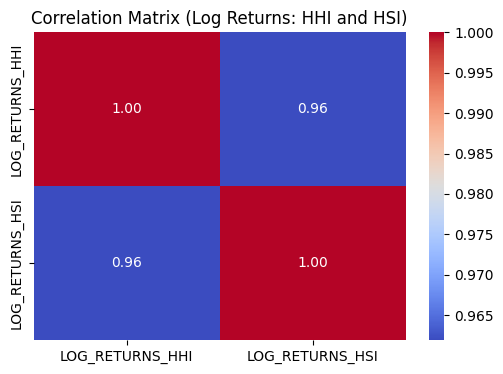


Pearson Correlation between LOG_RETURNS_HHI and LOG_RETURNS_HSI: 0.9619 (p-value: 0.0000)


In [6]:
# Step 2: Correlation Analysis
columns_to_analyze = ['LOG_RETURNS_HHI', 'LOG_RETURNS_HSI']
correlations = data[columns_to_analyze].corr()

# Plot correlation heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title('Correlation Matrix (Log Returns: HHI and HSI)')
plt.show()

# Pearson correlation for LOG_RETURNS_HHI and LOG_RETURNS_HSI
pearson_corr, p_value_corr = pearsonr(data['LOG_RETURNS_HHI'], data['LOG_RETURNS_HSI'])
print(f"\nPearson Correlation between LOG_RETURNS_HHI and LOG_RETURNS_HSI: {pearson_corr:.4f} (p-value: {p_value_corr:.4f})")

In [7]:
# Stationarity Test (ADF Test)

def adf_test(series, name):
    adf_stat, p_value, _, _, critical_values, _ = adfuller(series)
    print(f"\nADF Test for {name}:")
    print(f"ADF Statistic: {adf_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Critical Values: {critical_values}")
    if p_value < 0.05:
        print(f"The series {name} is stationary (reject null hypothesis).")
    else:
        print(f"The series {name} is not stationary (fail to reject null hypothesis).")

adf_test(data['LOG_RETURNS_HSI'], 'LOG_RETURNS_HSI')
adf_test(data['LOG_RETURNS_HHI'], 'LOG_RETURNS_HHI')



ADF Test for LOG_RETURNS_HSI:
ADF Statistic: -81.4385
p-value: 0.0000
Critical Values: {'1%': -3.430359579729587, '5%': -2.861544234130217, '10%': -2.5667722536724114}
The series LOG_RETURNS_HSI is stationary (reject null hypothesis).

ADF Test for LOG_RETURNS_HHI:
ADF Statistic: -81.4983
p-value: 0.0000
Critical Values: {'1%': -3.430359579729587, '5%': -2.861544234130217, '10%': -2.5667722536724114}
The series LOG_RETURNS_HHI is stationary (reject null hypothesis).


In [8]:
from statsmodels.tsa.stattools import coint

# Perform the cointegration test
coint_stat, p_value, critical_values = coint(data['LOG_RETURNS_HSI'], data['LOG_RETURNS_HHI'])

# Print the results
print("Cointegration Test Results:")
print(f"Cointegration Statistic: {coint_stat:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Critical Values: {critical_values}")

# Interpret the result
if p_value < 0.05:
    print("The series are cointegrated (reject the null hypothesis of no cointegration).")
else:
    print("The series are not cointegrated (fail to reject the null hypothesis).")

Cointegration Test Results:
Cointegration Statistic: -103.0541
p-value: 0.0000
Critical Values: [-3.89645604 -3.33613895 -3.04445621]
The series are cointegrated (reject the null hypothesis of no cointegration).


                            OLS Regression Results                            
Dep. Variable:        LOG_RETURNS_HSI   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                 8.450e+06
Date:                Sun, 15 Dec 2024   Prob (F-statistic):               0.00
Time:                        17:36:44   Log-Likelihood:             5.0988e+06
No. Observations:              682723   AIC:                        -1.020e+07
Df Residuals:                  682721   BIC:                        -1.020e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            6.915e-08   1.67e-07     

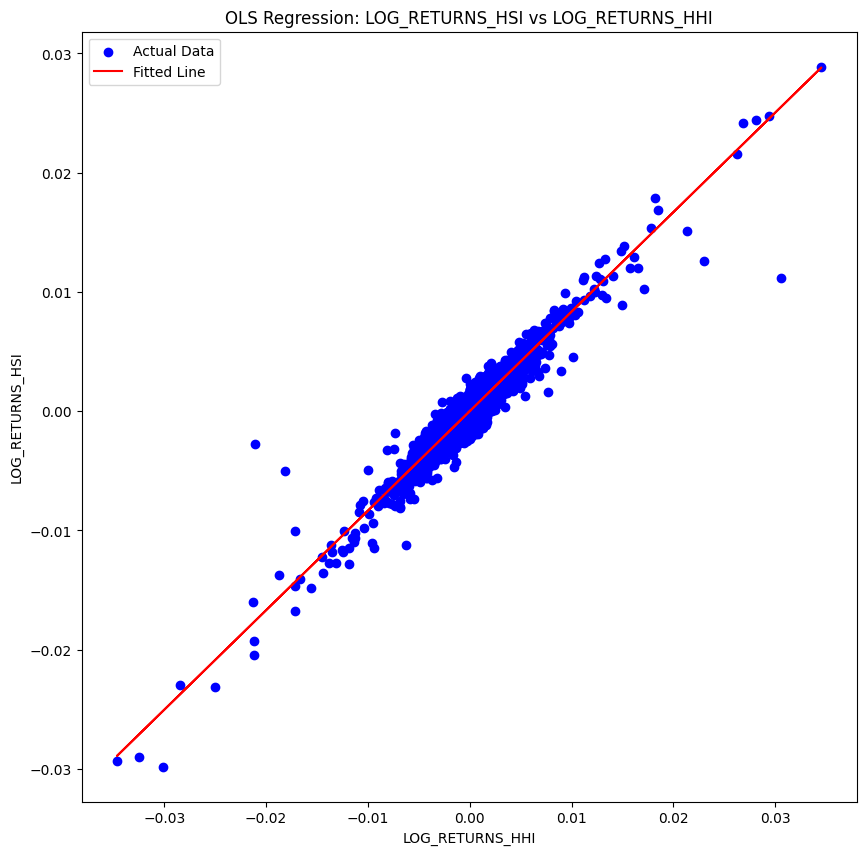

In [9]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Add a constant to the independent variable (intercept term)
X = sm.add_constant(data['LOG_RETURNS_HHI'])

# Fit the Ordinary Least Squares (OLS) regression model
model = sm.OLS(data['LOG_RETURNS_HSI'], X).fit()

# Predict values based on the model
data['predicted_HSI'] = model.predict(X)

# Print the Model summary
print(model.summary())

# Create the plot
plt.figure(figsize=(10, 10))

# Scatter plot of the actual data
plt.scatter(data['LOG_RETURNS_HHI'], data['LOG_RETURNS_HSI'], color='blue', label='Actual Data')

# Plot the regression line
plt.plot(data['LOG_RETURNS_HHI'], data['predicted_HSI'], color='red', label='Fitted Line')

# Add labels and title
plt.xlabel('LOG_RETURNS_HHI')
plt.ylabel('LOG_RETURNS_HSI')
plt.title('OLS Regression: LOG_RETURNS_HSI vs LOG_RETURNS_HHI')

# Display the legend
plt.legend()

# Show the plot
plt.show()

In [15]:
import numpy as np

# Compute condition number of the design matrix
X = sm.add_constant(data['LOG_RETURNS_HHI'])
condition_number = np.linalg.cond(X)
print("Condition Number:", condition_number)


Condition Number: 1717.0377063926749


In [17]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# Standardize the independent variable
scaler = StandardScaler()
data['LOG_RETURNS_HHI_scaled'] = scaler.fit_transform(data[['LOG_RETURNS_HHI']])

# Refit the regression model with scaled data
X_scaled = sm.add_constant(data['LOG_RETURNS_HHI_scaled'])
model_scaled = sm.OLS(data['LOG_RETURNS_HSI'], X_scaled).fit()

# Compute the new condition number
import numpy as np
condition_number_scaled = np.linalg.cond(X_scaled)
print("Condition Number after Scaling:", condition_number_scaled)

# Print the model summary
print(model_scaled.summary())


Condition Number after Scaling: 1.000000000000932
                            OLS Regression Results                            
Dep. Variable:        LOG_RETURNS_HSI   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                 8.450e+06
Date:                Sun, 15 Dec 2024   Prob (F-statistic):               0.00
Time:                        17:47:13   Log-Likelihood:             5.0988e+06
No. Observations:              682723   AIC:                        -1.020e+07
Df Residuals:                  682721   BIC:                        -1.020e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

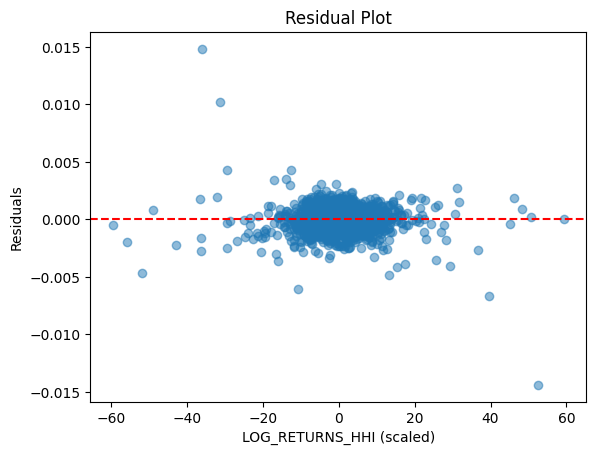

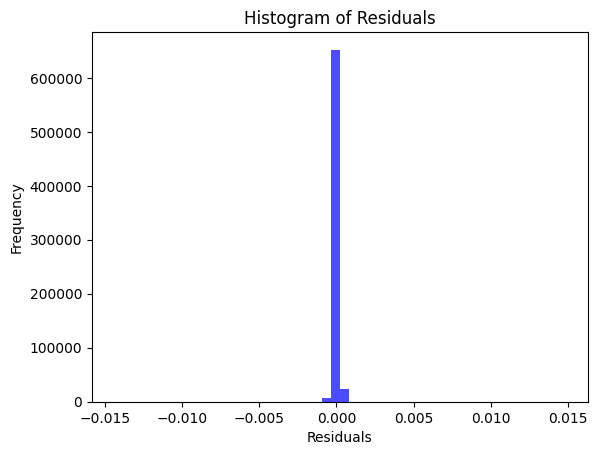

In [18]:
# Residual diagnostics
residuals = model_scaled.resid

# Residual plot
plt.scatter(data['LOG_RETURNS_HHI_scaled'], residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('LOG_RETURNS_HHI (scaled)')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Plot distribution of residuals
plt.hist(residuals, bins=50, alpha=0.7, color='blue')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


In [19]:
from scipy.stats import shapiro

# Shapiro-Wilk test for normality
stat, p = shapiro(residuals[:5000])  # Test only on a sample to avoid memory issues
print('Shapiro-Wilk Test Statistic:', stat)
print('p-value:', p)

Shapiro-Wilk Test Statistic: 0.8967984726151962
p-value: 9.65000558890202e-50


In [20]:
model_robust = sm.OLS(data['LOG_RETURNS_HSI'], X_scaled).fit(cov_type='HC3')
print(model_robust.summary())


                            OLS Regression Results                            
Dep. Variable:        LOG_RETURNS_HSI   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                 8.170e+04
Date:                Sun, 15 Dec 2024   Prob (F-statistic):               0.00
Time:                        17:50:03   Log-Likelihood:             5.0988e+06
No. Observations:              682723   AIC:                        -1.020e+07
Df Residuals:                  682721   BIC:                        -1.020e+07
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -6.71

In [21]:
from sklearn.preprocessing import PolynomialFeatures

# Add quadratic term
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(data[['LOG_RETURNS_HHI_scaled']])

# Fit the new model with polynomial features
X_poly = sm.add_constant(X_poly)
model_poly = sm.OLS(data['LOG_RETURNS_HSI'], X_poly).fit(cov_type='HC3')

# Print the summary
print(model_poly.summary())


                            OLS Regression Results                            
Dep. Variable:        LOG_RETURNS_HSI   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                 4.340e+04
Date:                Sun, 15 Dec 2024   Prob (F-statistic):               0.00
Time:                        17:51:23   Log-Likelihood:             5.0995e+06
No. Observations:              682723   AIC:                        -1.020e+07
Df Residuals:                  682720   BIC:                        -1.020e+07
Df Model:                           2                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.958e-07    4.1e-07     -0.478      0.6

In [22]:
from sklearn.linear_model import HuberRegressor

# Fit Huber Regression
huber = HuberRegressor()
huber.fit(data[['LOG_RETURNS_HHI_scaled']], data['LOG_RETURNS_HSI'])

print("Huber Coefficient:", huber.coef_)


Huber Coefficient: [0.00048707]


In [23]:
# Fit the final model with only the significant term
X_final = sm.add_constant(data['LOG_RETURNS_HHI_scaled'])
model_final = sm.OLS(data['LOG_RETURNS_HSI'], X_final).fit(cov_type='HC3')

# Print summary
print(model_final.summary())


                            OLS Regression Results                            
Dep. Variable:        LOG_RETURNS_HSI   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                 8.170e+04
Date:                Sun, 15 Dec 2024   Prob (F-statistic):               0.00
Time:                        17:53:05   Log-Likelihood:             5.0988e+06
No. Observations:              682723   AIC:                        -1.020e+07
Df Residuals:                  682721   BIC:                        -1.020e+07
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -6.71

In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Check VIF for predictors
X = sm.add_constant(data['LOG_RETURNS_HHI_scaled'])
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("VIF values:", vif)


VIF values: [1.0, 0.999999999999472]


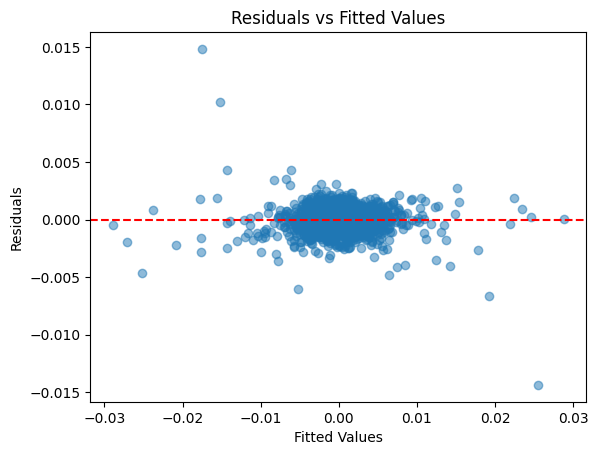

In [25]:
import matplotlib.pyplot as plt

# Plot residuals
residuals = model.resid
fitted = model.fittedvalues

plt.scatter(fitted, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()


In [26]:
from statsmodels.robust.robust_linear_model import RLM

# Fit robust regression
rlm_model = sm.RLM(data['LOG_RETURNS_HSI'], X, M=sm.robust.norms.HuberT())
rlm_results = rlm_model.fit()
print(rlm_results.summary())


                    Robust linear Model Regression Results                    
Dep. Variable:        LOG_RETURNS_HSI   No. Observations:               682723
Model:                            RLM   Df Residuals:                   682721
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 15 Dec 2024                                         
Time:                        17:57:15                                         
No. Iterations:                    50                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -4.83

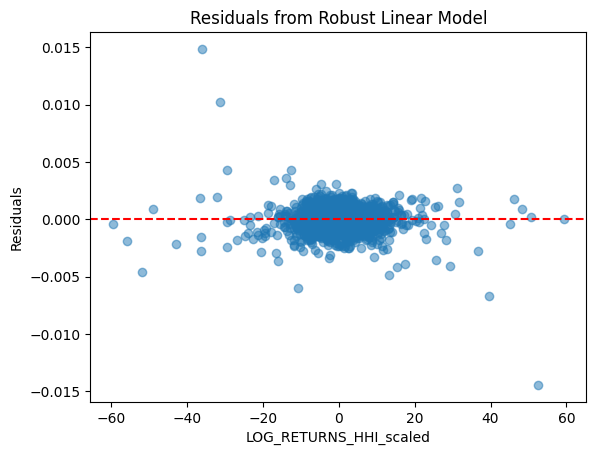

In [27]:
# Plot residuals from RLM
residuals_rlm = rlm_results.resid
plt.scatter(data['LOG_RETURNS_HHI_scaled'], residuals_rlm, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("LOG_RETURNS_HHI_scaled")
plt.ylabel("Residuals")
plt.title("Residuals from Robust Linear Model")
plt.show()


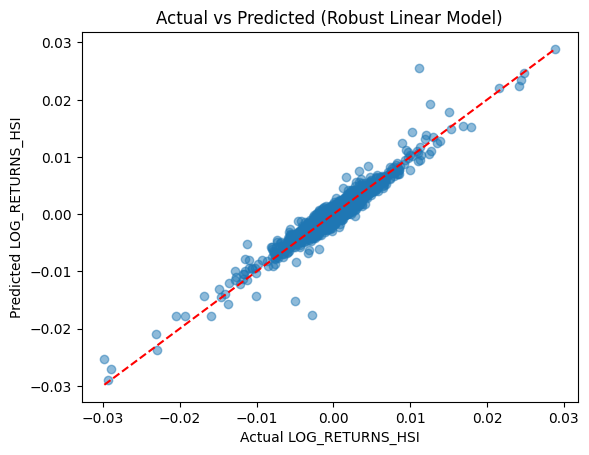

In [28]:
# Predicted values from RLM
data['predicted_RLM'] = rlm_results.predict()

# Scatter plot of actual vs predicted
plt.scatter(data['LOG_RETURNS_HSI'], data['predicted_RLM'], alpha=0.5)
plt.plot([data['LOG_RETURNS_HSI'].min(), data['LOG_RETURNS_HSI'].max()],
         [data['LOG_RETURNS_HSI'].min(), data['LOG_RETURNS_HSI'].max()],
         'r--')
plt.xlabel("Actual LOG_RETURNS_HSI")
plt.ylabel("Predicted LOG_RETURNS_HSI")
plt.title("Actual vs Predicted (Robust Linear Model)")
plt.show()


In [29]:
from sklearn.metrics import mean_squared_error, r2_score

# Compute metrics
y_actual = data['LOG_RETURNS_HSI']
y_pred = rlm_results.predict()
mse = mean_squared_error(y_actual, y_pred)
r2 = r2_score(y_actual, y_pred)

print(f"Mean Squared Error: {mse:.6e}")
print(f"R-squared: {r2:.4f}")

Mean Squared Error: 1.908391e-08
R-squared: 0.9252


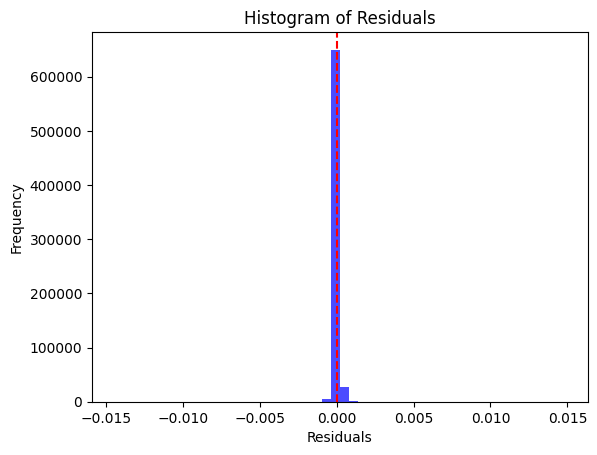

In [30]:
plt.hist(residuals_rlm, bins=50, color='blue', alpha=0.7)
plt.axvline(0, color='red', linestyle='--')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

In [31]:
from sklearn.preprocessing import StandardScaler

# Standardize the predictor
scaler = StandardScaler()
data['LOG_RETURNS_HHI_scaled'] = scaler.fit_transform(data[['LOG_RETURNS_HHI']])

In [33]:
# Re-scale and save scaled values
scaler = StandardScaler()
data['LOG_RETURNS_HHI_scaled'] = scaler.fit_transform(data[['LOG_RETURNS_HHI']])

# Confirm by printing the dataframe
data.head()

                   TIMESTAMP  LAST_PRICE_HSI  TURNOVER_VOLUME_HSI  \
1  2021-01-04 09:17:00+08:00         27145.0                452.0   
2  2021-01-04 09:18:00+08:00         27140.0                370.0   
3  2021-01-04 09:19:00+08:00         27133.0                293.0   
4  2021-01-04 09:20:00+08:00         27127.0                475.0   
5  2021-01-04 09:21:00+08:00         27132.0                313.0   

   LAST_BID_PRICE_HSI  LAST_ASK_PRICE_HSI  LAST_BID_VOLUME_HSI  \
1             27145.0             27147.0                  3.0   
2             27140.0             27143.0                  2.0   
3             27132.0             27135.0                  3.0   
4             27126.0             27128.0                  1.0   
5             27127.0             27130.0                  2.0   

   LAST_ASK_VOLUME_HSI  LAST_PRICE_HHI  TURNOVER_VOLUME_HHI  \
1                  2.0         10661.0                340.0   
2                  2.0         10659.0                214.0   

In [34]:
import statsmodels.api as sm

# Define the predictor and response
X_scaled = sm.add_constant(data['LOG_RETURNS_HHI_scaled'])  # Add constant for intercept
y = data['LOG_RETURNS_HSI']

# Fit the OLS model
model_scaled = sm.OLS(y, X_scaled).fit()

# Print the summary
print(model_scaled.summary())

                            OLS Regression Results                            
Dep. Variable:        LOG_RETURNS_HSI   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                 8.450e+06
Date:                Sun, 15 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:05:17   Log-Likelihood:             5.0988e+06
No. Observations:              682723   AIC:                        -1.020e+07
Df Residuals:                  682721   BIC:                        -1.020e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -6.71

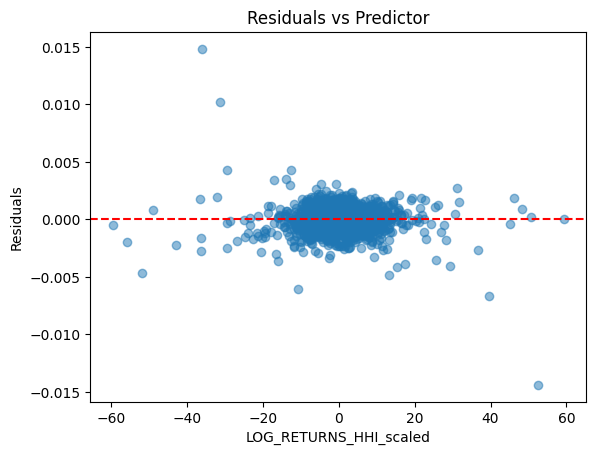

In [35]:
import matplotlib.pyplot as plt

residuals = model_scaled.resid
plt.scatter(data['LOG_RETURNS_HHI_scaled'], residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("LOG_RETURNS_HHI_scaled")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictor")
plt.show()

In [37]:
# Save OLS summary to a text file
with open('OLS_summary.txt', 'w') as f:
    f.write(model_scaled.summary().as_text())

print("OLS summary saved as 'OLS_summary.txt'")

OLS summary saved as 'OLS_summary.txt'


In [36]:
# Save the refined dataset to a CSV file
data.to_csv('processed_dataset.csv', index=False)
print("Refined dataset saved!")

Refined dataset saved!'


In [38]:
# Define the split ratio
train_ratio = 0.75  # 75% training, 25% testing

# Calculate the split index
split_index = int(len(data) * train_ratio)

# Split the data into train and test sets
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

# Save train and test sets to CSV files
train_data.to_csv("train_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)

In [6]:
train_data = pd.read_csv('train_data.csv')
train_data.head()

import statsmodels.api as sm

# Define predictors and response for the train dataset
X_train = sm.add_constant(train_data['LOG_RETURNS_HHI_scaled'])  # Add constant for intercept
y_train = train_data['LOG_RETURNS_HSI']

# Fit the OLS model on the train dataset
model_train = sm.OLS(y_train, X_train).fit()

# Print the summary of the OLS model fitted on train data
print(model_train.summary())

                            OLS Regression Results                            
Dep. Variable:        LOG_RETURNS_HSI   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                 6.170e+06
Date:                Sun, 15 Dec 2024   Prob (F-statistic):               0.00
Time:                        18:24:45   Log-Likelihood:             3.7999e+06
No. Observations:              512042   AIC:                        -7.600e+06
Df Residuals:                  512040   BIC:                        -7.600e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                  -6.09

In [7]:
with open('OLS_train_summary.txt', 'w') as f:
    f.write(model_train.summary().as_text())
print("OLS train summary saved as 'OLS_train_summary.txt'")


OLS train summary saved as 'OLS_train_summary.txt'


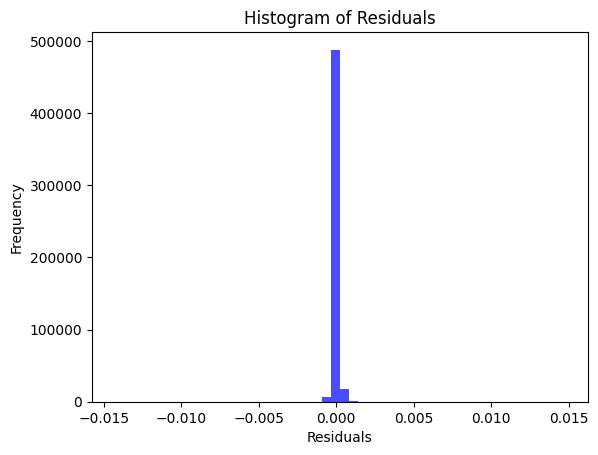

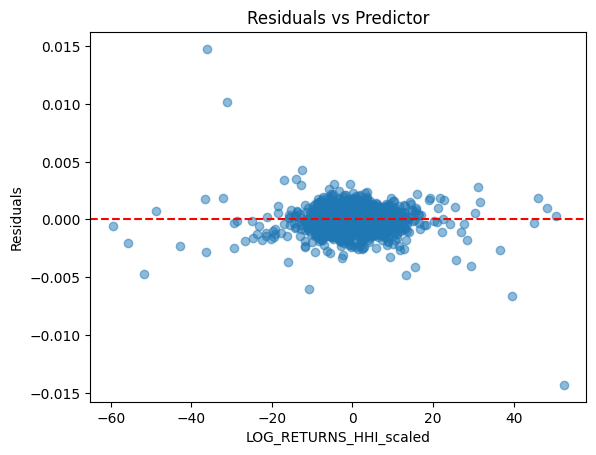

In [8]:
import matplotlib.pyplot as plt

# Residuals from the training model
residuals = model_train.resid

# Histogram of residuals
plt.hist(residuals, bins=50, color='blue', alpha=0.7)
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# Scatter plot of residuals
plt.scatter(train_data['LOG_RETURNS_HHI_scaled'], residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("LOG_RETURNS_HHI_scaled")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictor")
plt.show()


#### Save the updated train_data to a CSV file

In [15]:
train_data.to_csv('train_data.csv', index=False)
print("Updated train_data saved as 'train_data.csv'")

Updated train_data saved as 'train_data.csv'
